This notebook contains the modelling aspect of this project. We will be forecasting the rental prices of different SA2s in 2025, 2026, and 2027 to see which SA2s are projected to grow the most.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the cleaned DataFrame
df = pd.read_parquet('../data/curated/model_data.parquet')

df.head(5)



,bedrooms,bathrooms,propertyTypes,carspaces,latitude,longitude,price,is_furnished,year,SA2_CODE21,...,date_numeric,median_income,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,[apartmentUnitFlat],0.0,-37.815016,144.965968,380.0,0,2011,206041503,...,14,NaN,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,[apartmentUnitFlat],1.0,-37.816257,144.953288,550.0,0,2011,206041505,...,16,NaN,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,[apartmentUnitFlat],0.0,-37.821294,144.955768,370.0,0,2011,206041505,...,16,NaN,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,[apartmentUnitFlat],1.0,-37.760855,144.961691,429.0,0,2011,206011495,...,30,NaN,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,[apartmentUnitFlat],1.0,-37.810074,144.985476,460.0,0,2011,206041119,...,44,NaN,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


We will clean up the data one last time before modelling. We are excluding features that we won't use for the model as well as removing outliers.

In [2]:
cleaned_df = df.copy()

cleaned_df.drop(columns=['propertyTypes'], inplace=True)
cleaned_df.drop(columns=['days_on_market'], inplace=True)
cleaned_df.drop(columns=['longitude'], inplace=True)
cleaned_df.drop(columns=['latitude'], inplace=True)
cleaned_df.drop(columns=['median_income'], inplace=True)


# Initial count of rows
initial_count = cleaned_df.shape[0]

# Define outlier thresholds
price_threshold = cleaned_df['price'].quantile(0.995)  # Example threshold for high prices
bedrooms_threshold = 6  # Example threshold for maximum bedrooms
bathrooms_threshold = 7  # Example threshold for maximum bathrooms
carspaces_threshold = 4  # Example threshold for maximum carspaces

# Remove outliers based on defined thresholds
filtered_df = cleaned_df[
    (cleaned_df['price'] <= price_threshold) &
    (cleaned_df['bedrooms'] <= bedrooms_threshold) &
    (cleaned_df['bathrooms'] <= bathrooms_threshold) &
    (cleaned_df['carspaces'] <= carspaces_threshold)
]

# Count of rows after filtering
filtered_count = filtered_df.shape[0]

# Print counts before and after
print(f"Initial number of rows: {initial_count}")
print(f"Number of rows after outlier removal: {filtered_count}")

filtered_df.head(5)

Initial number of rows: 120526
Number of rows after outlier removal: 119574


,bedrooms,bathrooms,carspaces,price,is_furnished,year,SA2_CODE21,population,distance_to_bus_stop,distance_to_train_stop,...,bed_bath_interaction,date_numeric,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,0.0,380.0,0,2011,206041503,7939,0.003576,0.003437,...,1.0,14,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,1.0,550.0,0,2011,206041505,7475,0.001879,0.002518,...,2.0,16,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,0.0,370.0,0,2011,206041505,7475,0.002997,0.005501,...,1.0,16,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,1.0,429.0,0,2011,206011495,11981,0.000593,0.001079,...,2.0,30,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,1.0,460.0,0,2011,206041119,5238,0.001944,0.006598,...,2.0,44,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


Before forecasting, we need to validate the model that we use will have reasonable accuracy. We use data from 2011-2023 for training and will validate the model's performance on 2024 data.

In [3]:

# Define the target variable and features
target = 'price'
features = [col for col in filtered_df.columns if col != target]

# Split the data into train and test sets
train_data = filtered_df[filtered_df['year'].between(2011, 2023)]
test_data = filtered_df[filtered_df['year'] == 2024]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


Hyperparameter tuning is done over multiple runs to see which hyperparameters are best for the model.

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from collections import Counter

# Sample 20% of the training data for each round of grid search
sample_fraction = 0.2

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Store results from different random state runs
results = []
best_params_list = []

# Run multiple rounds of grid search with different random states for data sampling
for run in range(10):
    # Use different random states for each sampling round
    random_state_sample = np.random.randint(0, 1000)

    # Sample the training data
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, train_size=sample_fraction, random_state=random_state_sample
    )

    # Concatenate training and evaluation data to create a single dataset
    X_combined = pd.concat([X_train_sampled, X_test])
    y_combined = pd.concat([y_train_sampled, y_test])

    # Create a predefined split: -1 for train, 0 for test
    test_fold = [-1] * len(X_train_sampled) + [0] * len(X_test)
    ps = PredefinedSplit(test_fold)

    # Initialize the RandomForestRegressor model
    rf_reg = RandomForestRegressor(random_state=42)  # Random state here controls only reproducibility for the RF itself

    # Setup GridSearchCV with the predefined split
    grid_search = GridSearchCV(
        estimator=rf_reg, param_grid=param_grid,
        scoring='neg_root_mean_squared_error', cv=ps, n_jobs=-1, verbose=1
    )

    # Fit the model using the predefined train-test split
    grid_search.fit(X_combined, y_combined)

    # Store the results for this random state
    results.append({
        "random_state_sample": random_state_sample,
        "best_params": grid_search.best_params_,
        "best_score": -grid_search.best_score_  # Negative sign because `neg_root_mean_squared_error` is used
    })

    best_params_list.append(grid_search.best_params_)
    print(f"Run {run + 1}: Best parameters found: {grid_search.best_params_}")
    print(f"Run {run + 1}: Best RMSE score found: {-grid_search.best_score_}")

# Find the most common parameters across runs
most_common_params = Counter(tuple(sorted(p.items())) for p in best_params_list).most_common(1)
print("Most common hyperparameters across runs:", most_common_params)


Fitting 1 folds for each of 216 candidates, totalling 216 fits


KeyboardInterrupt: 

Then, we run 2 models using all the training and validation set to see which set of hyperparameters result in a better model.

In [4]:

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

# Train the Random Forest Regressor
rf_model2 = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model2.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model2.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse2:.2f}")


Root Mean Squared Error (RMSE) of Random Forest Regressor: 82.89
Root Mean Squared Error (RMSE) of Random Forest Regressor: 85.64


Plot out the feature importances from the better model

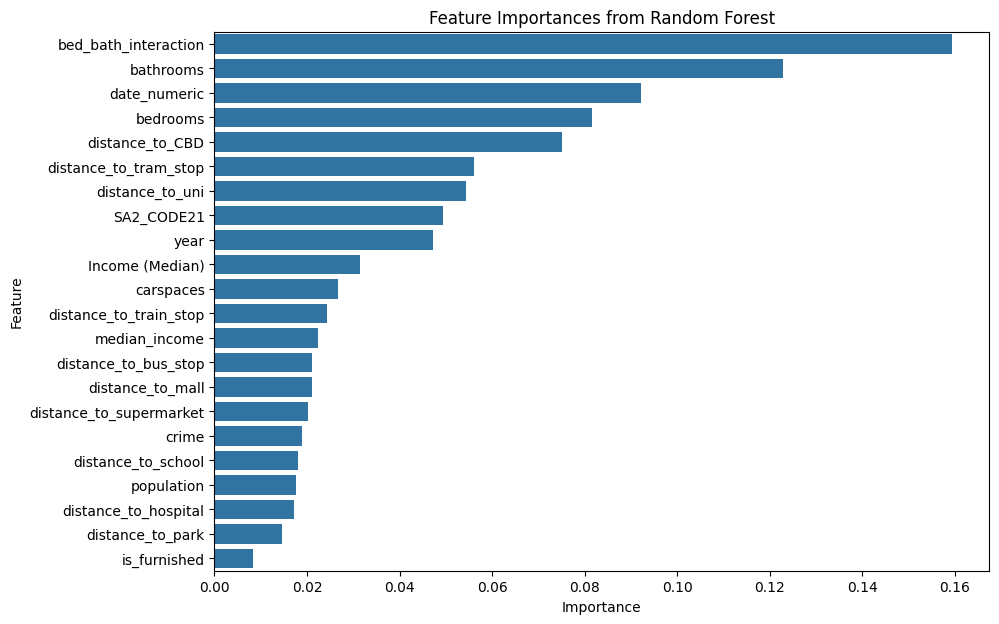

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

We will also attempt to perform recursive feature elimination to see if reducing the number of features would result in a better model that hopefully has a lesser chance at overfitting.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the model
rf_model_fs = RandomForestRegressor(n_estimators=250, bootstrap=True, max_depth=None, 
                                     max_features='sqrt', min_samples_leaf=1, 
                                     min_samples_split=5, random_state=42)

# Initialize lists to store results
num_features = []
rmses = []

# Define the maximum number of features you want to evaluate
max_features = X_train.shape[1] - 2  # Adjust based on your dataset

feature_list = [12, 13, 19, 20]

# Perform RFE for different numbers of features
for i in feature_list:
    # Perform RFE with the current number of features
    rfe = RFE(estimator=rf_model_fs, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    
    # Get the selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model with selected features
    rf_model_fs.fit(X_train[selected_features], y_train)
    
    # Predict on the test set
    y_pred = rf_model_fs.predict(X_test[selected_features])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=True))
    
    # Store the results
    num_features.append(i)
    rmses.append(rmse)

# Find the optimal number of features based on RMSE
optimal_features_index = np.argmin(rmses)
optimal_num_features = num_features[optimal_features_index]
optimal_rmse = rmses[optimal_features_index]

# Print results
print(f"Optimal number of features: {optimal_num_features}")
print(f"Best RMSE: {optimal_rmse}")

# Plot the number of features vs. RMSE
plt.figure(figsize=(10, 6))
plt.plot(num_features, rmses, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Optimal Number of Features via RFE')
plt.grid()
plt.axvline(x=optimal_num_features, linestyle='--', color='red', label='Optimal Features')
plt.legend()
plt.show()


In [13]:
selected_features_rfe = X_train.columns[rfe.support_]
X_train_top = X_train[selected_features_rfe]
X_test_top = X_test[selected_features_rfe]


# Train a new Random Forest Regressor with the top 12 features
rf_model_top = RandomForestRegressor(n_estimators=250, bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
rf_model_top.fit(X_train_top, y_train)

# Make predictions and compute RMSE for the new model
y_pred_top = rf_model_top.predict(X_test_top)
rmse_top = np.sqrt(mean_squared_error(y_test, y_pred_top))

print(f"Root Mean Squared Error (RMSE) of Random Forest with Top 12 Features: {rmse_top:.2f}")


Root Mean Squared Error (RMSE) of Random Forest with Top 12 Features: 83.03


As the reduced model performed slightly worse, we decide to use the full model especially since the model does not have too many features considering the size of the dataset.

We also compared the RF model performance with a LR model

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Root Mean Squared Error (RMSE) of Linear Regression Model: {rmse_lr:.2f}")

Root Mean Squared Error (RMSE) of Linear Regression Model: 160.13


Now, we will begin forecasting. We will use the entire dataset from 2011 to 2024 as our training data and will use our generated test data to forecast prices into the future.

In [3]:
# Define the target variable and features
target = 'price'
features = [col for col in filtered_df.columns if col != target]

train_data = filtered_df[filtered_df['year'].between(2011, 2024)]

X_train = train_data[features]
y_train = train_data[target]

test_data = pd.read_csv('../data/curated/test_data.csv')


In [53]:
train_data.head(10)

,bedrooms,bathrooms,carspaces,price,is_furnished,year,SA2_CODE21,population,distance_to_bus_stop,distance_to_train_stop,...,bed_bath_interaction,date_numeric,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.00,1.00,0.00,380.00,0,2011,206041503,7939,0.00,0.00,...,1.00,14,0.00,0.00,0.00,0.00,0.00,0.01,0.01,1266.44
1,2.00,1.00,1.00,550.00,0,2011,206041505,7475,0.00,0.00,...,2.00,16,0.00,0.00,0.00,0.00,0.01,0.00,0.01,1192.42
2,1.00,1.00,0.00,370.00,0,2011,206041505,7475,0.00,0.01,...,1.00,16,0.01,0.00,0.00,0.01,0.01,0.01,0.02,1192.42
3,2.00,1.00,1.00,429.00,0,2011,206011495,11981,0.00,0.00,...,2.00,30,0.00,0.00,0.00,0.01,0.06,0.01,0.04,820.15
4,2.00,1.00,1.00,460.00,0,2011,206041119,5238,0.00,0.01,...,2.00,44,0.00,0.00,0.00,0.01,0.02,0.01,0.02,835.57
5,1.00,1.00,0.00,370.00,0,2011,206041505,7475,0.00,0.00,...,1.00,54,0.01,0.00,0.00,0.00,0.02,0.00,0.01,1192.42
6,2.00,1.00,1.00,479.00,0,2011,206051513,10751,0.00,0.01,...,2.00,55,0.01,0.01,0.00,0.01,0.05,0.01,0.06,993.73
7,1.00,1.00,0.00,550.00,1,2011,206041504,6401,0.00,0.00,...,1.00,59,0.00,0.00,0.00,0.00,0.01,0.01,0.00,1021.09
8,2.00,1.00,1.00,430.00,0,2011,206011495,11981,0.00,0.00,...,2.00,60,0.00,0.00,0.00,0.01,0.06,0.01,0.04,820.15
9,2.00,1.00,1.00,700.00,1,2011,206041119,5238,0.00,0.01,...,2.00,62,0.00,0.00,0.00,0.01,0.02,0.01,0.02,835.57


In [11]:
test_data.head(10)

,SA2_CODE21,bedrooms,bathrooms,year,distance_to_bus_stop,distance_to_train_stop,distance_to_tram_stop,distance_to_hospital,distance_to_mall,distance_to_park,distance_to_supermarket,distance_to_CBD,distance_to_school,distance_to_uni,population,date_numeric,bed_bath_interaction,carspaces,is_furnished,crime
0,201011006,1,1,2025,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,15294,5295,1,1,1,1210.912850
1,201011006,1,1,2026,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,16366,5660,1,1,0,1290.087583
2,201011006,1,1,2027,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,17341,6025,1,1,0,1366.340312
3,201011006,1,1,2025,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,15294,5295,1,0,0,1210.912850
4,201011006,1,1,2026,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,16366,5660,1,0,1,1290.087583
5,201011006,1,1,2027,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,17341,6025,1,0,1,1366.340312
6,201011006,2,1,2025,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,15294,5295,2,1,1,1210.912850
7,201011006,2,1,2026,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,16366,5660,2,1,0,1290.087583
8,201011006,2,1,2027,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,17341,6025,2,1,0,1366.340312
9,201011006,2,1,2025,0.741864,0.91511,1.091632,0.036647,0.007196,0.00017,0.008238,1.188191,0.03149,1.178579,15294,5295,2,0,0,1210.912850


Fit the RF model and use it to predict the price on the test data.

In [35]:
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=250, random_state=42)

In [36]:
test_data = test_data[X_train.columns]  # Ensure test_data has the same columns as X_train
test_data['predicted_target'] = rf_model.predict(test_data)

Feature Importances:
                    Feature  Importance
10     bed_bath_interaction    0.156511
11             date_numeric    0.127944
1                 bathrooms    0.111481
0                  bedrooms    0.079459
4                      year    0.079004
16          distance_to_CBD    0.074583
9     distance_to_tram_stop    0.054717
5                SA2_CODE21    0.054574
18          distance_to_uni    0.053796
2                 carspaces    0.025054
8    distance_to_train_stop    0.024757
15         distance_to_mall    0.022012
7      distance_to_bus_stop    0.021607
13  distance_to_supermarket    0.019710
19                    crime    0.019418
6                population    0.018664
17       distance_to_school    0.017915
12     distance_to_hospital    0.017076
14         distance_to_park    0.014190
3              is_furnished    0.007529


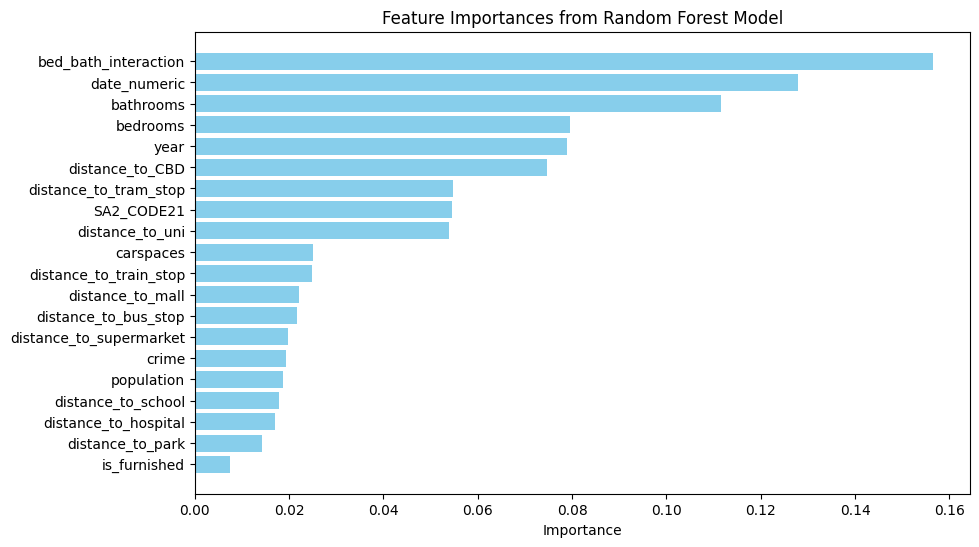

In [16]:
import matplotlib.pyplot as plt

# Check feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

Output the predicted average price for each SA2 and rank them based on the SA2s that are predicted to have the highest growth

In [7]:
import pandas as pd
from tabulate import tabulate

# Load population data (or suburb data)
population_df = pd.read_csv('../data/curated/forecasted_populations.csv')

# Ensure 'SA2_CODE21' is numeric
population_df['SA2_CODE21'] = pd.to_numeric(population_df['Code'], errors='coerce')
test_data['SA2_CODE21'] = pd.to_numeric(test_data['SA2_CODE21'], errors='coerce')

# Drop NaN values and duplicates
population_df = population_df.dropna(subset=['SA2_CODE21']).drop_duplicates(subset='SA2_CODE21')

# Create a DataFrame for 2025, 2026, and 2027 prices
pivot_data = test_data.pivot_table(
    index='SA2_CODE21',
    columns='year',
    values='predicted_target'
).reset_index()

# Rename the columns for clarity
pivot_data.columns.name = None  # Remove the column index name
pivot_data.columns = ['SA2_CODE21', 'predicted_price_2025', 'predicted_price_2026', 'predicted_price_2027']

# Calculate actual growth and percentage growth for each SA2
pivot_data['actual_growth'] = pivot_data['predicted_price_2027'] - pivot_data['predicted_price_2025']
pivot_data['percentage_growth'] = (pivot_data['actual_growth'] / pivot_data['predicted_price_2025']) * 100

# Group by SA2_CODE21 to calculate average growth metrics
sa2_growth = pivot_data.groupby('SA2_CODE21').agg({
    'predicted_price_2025': 'mean',
    'predicted_price_2026': 'mean',
    'predicted_price_2027': 'mean',
    'actual_growth': 'mean',
    'percentage_growth': 'mean'
}).reset_index()

# Convert SA2_CODE21 to string to avoid scientific notation
sa2_growth['SA2_CODE21'] = sa2_growth['SA2_CODE21'].astype(int)

# Calculate the count of properties in the training data for each SA2
train_property_counts = train_data.groupby('SA2_CODE21').size().reset_index(name='property_count')

train_property_counts['SA2_CODE21'] = train_property_counts['SA2_CODE21'].astype(int)

# Merge the property count with sa2_growth data
sa2_growth_with_count = sa2_growth.merge(train_property_counts, on='SA2_CODE21', how='left')

# Merge with suburb names
sa2_growth_with_suburb = sa2_growth_with_count.merge(
    population_df[['SA2_CODE21', 'Suburb']], 
    on='SA2_CODE21', 
    how='left'
)

# Sort the districts by the calculated percentage growth
sa2_growth_with_suburb = sa2_growth_with_suburb.sort_values(by='percentage_growth', ascending=False)

# Output the SA2 districts with the highest predicted growth in listing prices using tabulate
print("SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (including property counts):")
print(tabulate(sa2_growth_with_suburb, headers='keys', tablefmt='psql', showindex=False))


SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (including property counts):
+--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------+
|   SA2_CODE21 |   predicted_price_2025 |   predicted_price_2026 |   predicted_price_2027 |   actual_growth |   percentage_growth |   property_count | Suburb                                        |
|--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------|
|    212041563 |                513.071 |                514.284 |                519.778 |      6.7065     |         1.30713     |              151 | Dandenong - North                             |
|    210051445 |                490.277 |                494.059 |                49

Filter for only SA2s that have more than 50 listings in the training data so that the results are more accurate and not affected by sampling bias

In [13]:
# Remove rows where property counts are 50 or less
sa2_growth_filtered = sa2_growth_with_suburb[sa2_growth_with_suburb['property_count'] > 50]

# Print the filtered table again
print("SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (filtered for property counts > 50):")
print(tabulate(sa2_growth_filtered, headers='keys', tablefmt='psql', showindex=False))

# Save the filtered DataFrame to a CSV file
sa2_growth_filtered.to_csv('../data/curated/sa2_growth_filtered.csv', index=False)


SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (filtered for property counts > 50):
+--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------+
|   SA2_CODE21 |   predicted_price_2025 |   predicted_price_2026 |   predicted_price_2027 |   actual_growth |   percentage_growth |   property_count | Suburb                                        |
|--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------|
|    212041563 |                513.071 |                514.284 |                519.778 |      6.7065     |         1.30713     |              151 | Dandenong - North                             |
|    210051445 |                490.277 |                494.059 |          

Save the test data

In [14]:
# Save the test_data DataFrame as a CSV file
test_data.to_csv('../data/curated/test_data_priced.csv', index=False)
